In [17]:
# Import packages
from tools.to_read import *
from tools.to_plot import *
from tools.to_do import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set up
root='/home/jacoponudo/Documents/Size_effects/'
platform = input('Please enter the value for platform: ')

# Read data
data = pd.read_parquet(root + 'DATA/' + platform + '/'+platform+'_raw_data.parquet', columns=columns_to_read[platform])
data.columns=standard_columns
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Dinamiche collettive 

#### 1. Numero di utenti coinvolti in una conversazione

In [2]:
unique_users_per_post = data.groupby('post_id')['user_id'].nunique().reset_index()
unique_users_per_post.columns = ['post_id', 'unique_users_count']
unique_users_per_post.to_csv(root+'PAPER/output/1_section/1_users_in_thread_{}.csv'.format(platform))

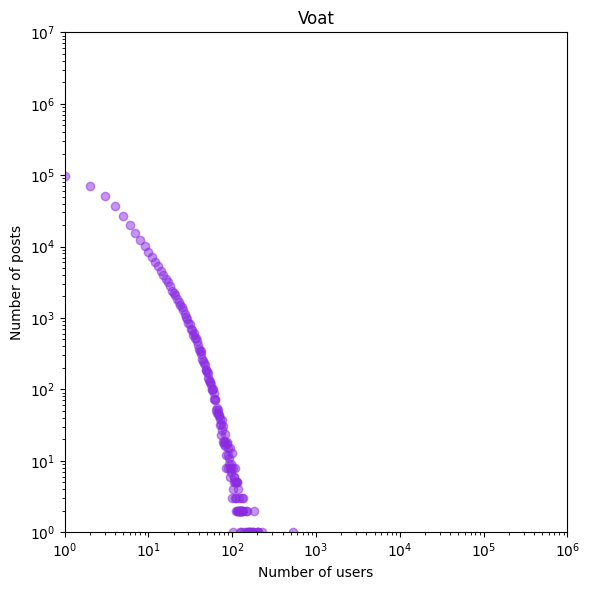

In [3]:
# Assuming the root and platform variables are defined
unique_users_per_post = pd.read_csv(root+'PAPER/output/1_section/1_users_in_thread_{}.csv'.format(platform))
distribution = unique_users_per_post['unique_users_count'].value_counts().sort_index()

plt.figure(figsize=(6, 6))
plt.scatter(distribution.index, distribution.values, color=palette[platform], alpha=0.5)  # Alpha added for transparency
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 10**6)  # Set x-axis limits between 1 and 10^6
plt.ylim(1, 10**7)  # Set y-axis limits between 1 and 10^6
plt.xlabel('Number of users')
plt.ylabel('Number of posts')
plt.title(str(platform.capitalize()))
plt.grid(False)
plt.tight_layout()

plt.savefig(root+'PAPER/output/1_section/1_users_in_thread_{}.png'.format(platform))
plt.show()

#### 2. Durata della conversazione

In [4]:


# Esempio di utilizzo: calcolare il 95° percentile e salvare il file
output_path =root+'PAPER/output/1_section/2_lifetime_thread_{}.csv'.format(platform)
calculate_lifetime_percentile(data, 80, output_path)

Calcolando durata 80° percentile per ogni post: 100%|██████████| 413854/413854 [02:40<00:00, 2578.67it/s]


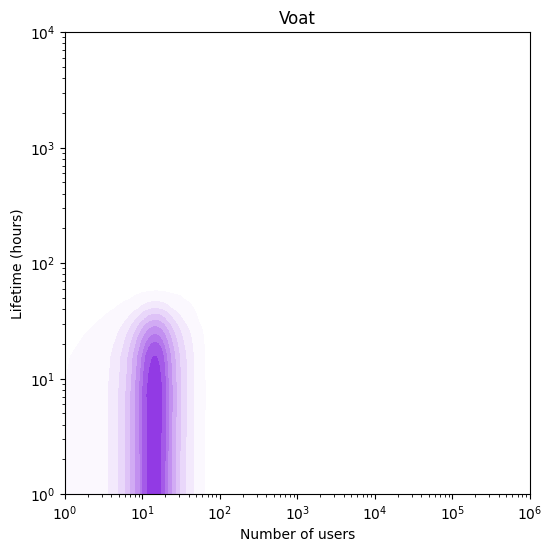

In [ ]:

# Load the data
output_path = root + 'PAPER/output/1_section/2_lifetime_thread_{}.csv'.format(platform)
df = pd.read_csv(output_path, dtype={'post_id': str})

# Remove NA values from the 'duration_percentile' column
df = df.dropna(subset=['duration_percentile','unique_user_count'])
# Filter rows where 'unique_user_count' is greater than 50
df = df[df['unique_user_count'] > 10]
df=df.sample(5000)


# Create the density plot
plt.figure(figsize=(6, 6))
sns.kdeplot(
    data=df, 
    x="unique_user_count",
    y="duration_percentile",  
    fill=True, 
    cmap=LinearSegmentedColormap.from_list("platform_to_white", ['white', palette[platform]])
)
plt.title(str(platform.capitalize()))
plt.ylabel('Lifetime (hours)')
plt.xlabel('Number of users')

# Set log scale for both axes
plt.xscale('log')
plt.yscale('log')

# Limit the x-axis between 0 and 10^6, and y-axis between 0 and 10^4
plt.xlim(1, 10**6)
plt.ylim(1, 10**4)


# Save the plot
plt.savefig(root + 'PAPER/output/1_section/2_lifetime_thread_{}.png'.format(platform))
plt.show()


#### 3. Concentration of the conversation

In [6]:
# Conta il numero di utenti univoci per ciascun post
unique_users_per_post = data.groupby('post_id')['user_id'].nunique().reset_index(name='unique_user_count')

# Calcola la concentrazione assoluta massima e relativa dei commenti (come già mostrato)
data['hour'] = data['timestamp'].dt.floor('H')
comments_per_hour = data.groupby(['post_id', 'hour']).size().reset_index(name='comment_count')
max_concentration = comments_per_hour.groupby('post_id')['comment_count'].max().reset_index(name='max_absolute_concentration')

total_comments = data.groupby('post_id').size().reset_index(name='total_comments')
results_df = pd.merge(max_concentration, total_comments, on='post_id')
results_df['relative_concentration'] = results_df['max_absolute_concentration'] / results_df['total_comments']

# Aggiungi il conteggio degli utenti univoci
results_df = pd.merge(results_df, unique_users_per_post, on='post_id')

# Salva il risultato
results_df.to_csv(root+'PAPER/output/1_section/3_concentration_of_comments_{}.csv'.format(platform))


/tmp/ipykernel_783132/2980163939.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data['hour'] = data['timestamp'].dt.floor('H')


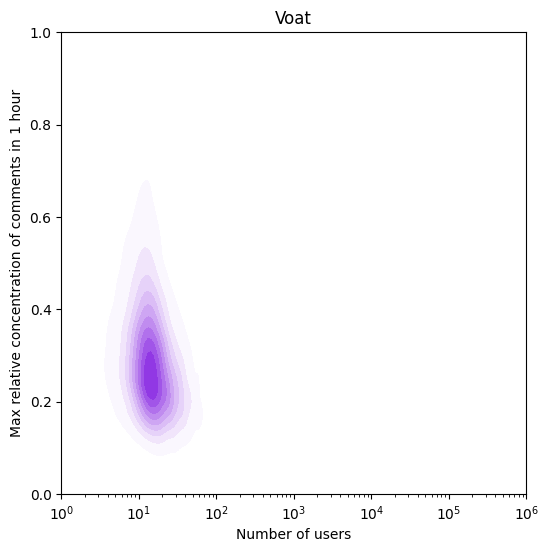

In [7]:
results_df=pd.read_csv(root+'PAPER/output/1_section/3_concentration_of_comments_{}.csv'.format(platform))



filtered_results_df = results_df[results_df['unique_user_count'] > 10]
filtered_results_df=filtered_results_df.sample(5000)
platform_color = palette[platform]  # Ad esempio, il colore arancione che volevi usare

# Definire una scala di colori che parte da 'platform_color' e termina con il bianco
cmap = LinearSegmentedColormap.from_list("platform_to_white", [ 'white',platform_color])

# Supponiamo che il tuo dataframe si chiami 'filtered_results_df'
plt.figure(figsize=(6, 6))
sns.kdeplot(x=filtered_results_df['unique_user_count'], y=filtered_results_df['relative_concentration'], cmap=cmap, fill=True)

plt.title(str(platform.capitalize()))
plt.ylabel('Max relative concentration of comments in 1 hour')
plt.xlabel('Number of users')
plt.xscale('log')
plt.xlim(1, 10**6)
plt.ylim(0,1)
plt.grid(False)

plt.savefig(root+'PAPER/output/1_section/3_concentration_of_comments_{}.png'.format(platform))
plt.show()


#### 4. Level of dialogue

In [3]:
grouped = data.groupby(['user_id', 'post_id']).size().reset_index(name='comment_count')
user_count = data.groupby('post_id')['user_id'].nunique().reset_index(name='user_count')
result = grouped.merge(user_count, on='post_id', how='left')
bins = np.arange(0, 1020, 50)
result['user_count_bin'] = pd.cut(result['user_count'], bins=bins, right=False)
valid_bins = result['user_count_bin'].value_counts()[result['user_count_bin'].value_counts() > 100].index
result = result[result['user_count_bin'].isin(valid_bins)]
result['comment_count'] = result['comment_count'].apply(lambda x: 5 if x > 5 else x)
prob_dist = result.groupby(['user_count_bin', 'post_id'])['comment_count'].value_counts(normalize=True)

localization_results = prob_dist.groupby(['user_count_bin', 'post_id']).apply(lambda x: calculate_localization_parameter(x.values)).reset_index(name='localization_parameter')
localization_results.to_csv(root + f'PAPER/output/1_section/4_dialogue_level_{platform}.csv')

/tmp/ipykernel_212350/2497360174.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_dist = result.groupby(['user_count_bin', 'post_id'])['comment_count'].value_counts(normalize=True)
/tmp/ipykernel_212350/2497360174.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  localization_results = prob_dist.groupby(['user_count_bin', 'post_id']).apply(lambda x: calculate_localization_parameter(x.values)).reset_index(name='localization_parameter')


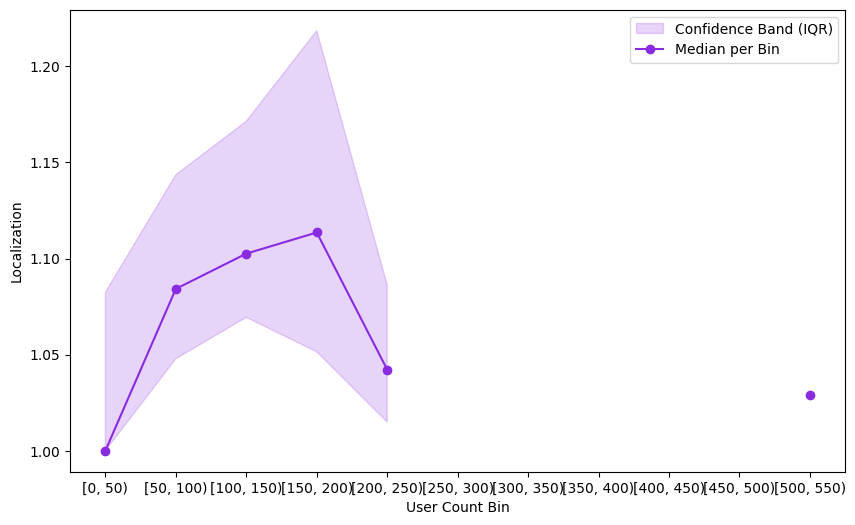

In [10]:
# Load the data
localization_results = pd.read_csv(f"{root}PAPER/output/1_section/4_dialogue_level_{platform}.csv")

# Group data by 'user_count_bin' and calculate median, Q1, and Q3 for 'localization_parameter'
median_values = localization_results.groupby('user_count_bin')['localization_parameter'].median().reset_index()
q1_values = localization_results.groupby('user_count_bin')['localization_parameter'].quantile(0.25).reset_index()
q3_values = localization_results.groupby('user_count_bin')['localization_parameter'].quantile(0.75).reset_index()

# Merge median, Q1, and Q3 values into a single DataFrame
conf_interval = pd.merge(median_values, q1_values[['user_count_bin', 'localization_parameter']], on='user_count_bin', suffixes=('', '_Q1'))
conf_interval = pd.merge(conf_interval, q3_values[['user_count_bin', 'localization_parameter']], on='user_count_bin', suffixes=('', '_Q3'))

# Sort values by 'user_count_bin' (converting to numeric if necessary)
localization_results['bin_lower_bound'] = localization_results['user_count_bin'].str.extract(r'(\d+)').astype(float)
conf_interval = conf_interval.merge(localization_results[['user_count_bin', 'bin_lower_bound']].drop_duplicates(), on='user_count_bin')
conf_interval = conf_interval.sort_values(by='bin_lower_bound').reset_index(drop=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.fill_between(conf_interval['user_count_bin'], conf_interval['localization_parameter_Q1'], conf_interval['localization_parameter_Q3'], color=palette[platform], alpha=0.2, label='Confidence Band (IQR)')
plt.plot(conf_interval['user_count_bin'], conf_interval['localization_parameter'], marker='o', color=palette[platform], label='Median per Bin')

# Add labels and legend
plt.xlabel('User Count Bin')
plt.ylabel('Localization')
plt.legend()
plt.savefig(root+'PAPER/output/1_section/4_dialogue_level_{}.png'.format(platform))
plt.show()

In [ ]:
platform_color = palette[platform]  # Ad esempio, il colore arancione che volevi usare

# Definire una scala di colori che parte da 'platform_color' e termina con il bianco
cmap = LinearSegmentedColormap.from_list("platform_to_white", [ 'white',platform_color])

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap

platforms = ['gab','reddit', 'twitter', 'usenet', 'voat', 'facebook']
for platform in platforms:
    data = pd.read_parquet(root + 'DATA/' + platform + '/' + platform + '_raw_data.parquet', columns=columns_to_read[platform])
    data.columns = standard_columns
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    df = data.sort_values(by=['post_id', 'timestamp'])
    sampled_posts = np.random.choice(df['post_id'].unique(), min(len(df['post_id'].unique()), 50000), replace=False)
    df = df[df['post_id'].isin(sampled_posts)]

    # Define maximum values for thread length (k) and participant count (d)
    max_k = 200
    max_d = 200

    # Create a matrix to store the density values
    density_matrix = np.zeros((max_d, max_k))

    # Group by each conversation (post_id)
    for post_id, group in tqdm(df.groupby('post_id'), desc=f"Processing {platform}"):
        # Sort comments within each conversation by timestamp
        group = group.sort_values(by='timestamp')

        # Loop over each possible thread prefix length k
        for k in range(1, max_k + 1):
            # Take the first k comments in this conversation
            top_k_comments = group.head(k)

            # Count the distinct users in the first k comments
            distinct_users_count = top_k_comments['user_id'].nunique()

            # Only consider counts up to max_d for the matrix
            if distinct_users_count <= max_d:
                density_matrix[distinct_users_count - 1, k - 1] += 1

    # Normalize the density matrix between 0 and 1
    density_matrix /= density_matrix.sum()

    # Save the density matrix as a CSV file
    density_df = pd.DataFrame(density_matrix, columns=[f"k={i}" for i in range(1, max_k + 1)],
                              index=[f"d={i}" for i in range(1, max_d + 1)])
    density_df.to_csv(f"/home/jacoponudo/Documents/Size_effects/PAPER/output/2_section/density_matrix_{platform}.csv", index=True)

    # Plotting the density matrix
    plt.figure(figsize=(10, 8))
    platform_color = palette[platform]
    cmap = LinearSegmentedColormap.from_list("platform_to_white", ['white', platform_color])
    sns.heatmap(density_matrix, cmap=cmap,
                cbar_kws={'label': 'Density'},
                xticklabels=range(1, max_k + 1),
                yticklabels=range(1, max_d + 1))

    plt.xlabel("Thread prefix length (k)")
    plt.ylabel("Number of distinct participants (d)")
    plt.title(f"{platform.capitalize()} Density Matrix")

    # Invert y-axis to start from the bottom
    plt.gca().invert_yaxis()

    # Save the plot
    plt.savefig(f"/home/jacoponudo/Documents/Size_effects/PAPER/output/2_section/heatmap_{platform}.png")

    # Display the plot
    plt.show()


Processing gab:   2%|▏         | 761/50000 [00:11<12:47, 64.12it/s]


KeyboardInterrupt: 

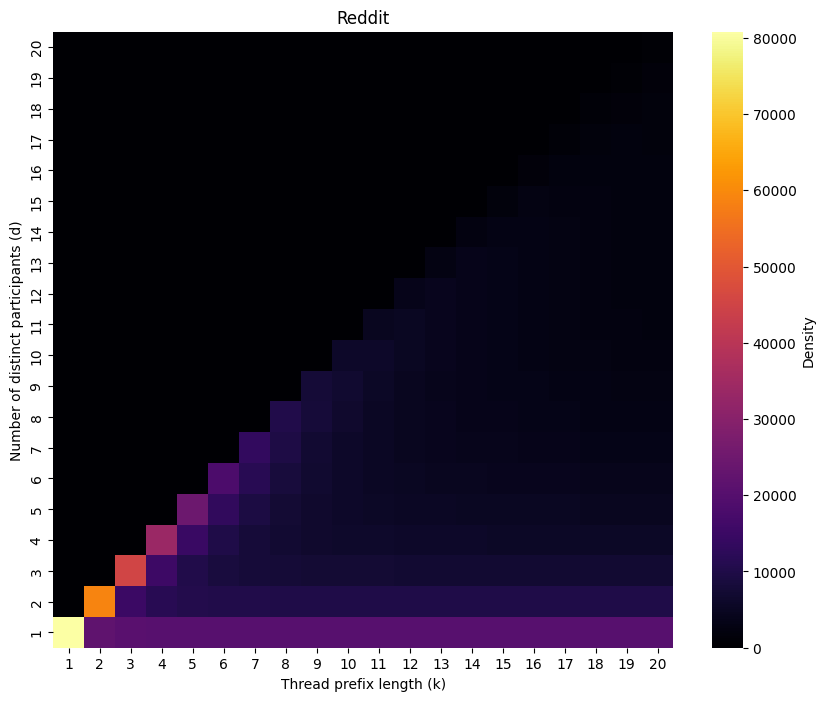

In [21]:
# Normalize the density matrix for color scale
density_matrix2 = density_matrix / density_matrix.sum(axis=1, keepdims=True)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(density_matrix, cmap="inferno", cbar=True, 
            cbar_kws={'label': 'Density'}, 
            xticklabels=range(1, max_k + 1), 
            yticklabels=range(1, max_d + 1))

plt.xlabel("Thread prefix length (k)")
plt.ylabel("Number of distinct participants (d)")
plt.title(str(platform.capitalize()))

# Invert y-axis to start from the bottom
plt.gca().invert_yaxis()

plt.show()


In [5]:
density_matrix2

array([[1.     , 0.17868, 0.167  , ..., 0.16542, 0.16542, 0.16542],
       [0.     , 0.82132, 0.12462, ..., 0.09666, 0.09666, 0.09666],
       [0.     , 0.     , 0.70838, ..., 0.06884, 0.06884, 0.06884],
       ...,
       [0.     , 0.     , 0.     , ..., 0.04736, 0.04562, 0.03222],
       [0.     , 0.     , 0.     , ..., 0.     , 0.0454 , 0.04446],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.04354]])

In [8]:
density_matrix
density_matrix / density_matrix.sum(axis=2, keepdims=True)

array([[0.07470471, 0.02024577, 0.01909862, ..., 0.01884626, 0.01884626,
        0.01884626],
       [0.        , 0.10820232, 0.02742433, ..., 0.01826697, 0.01826697,
        0.01826697],
       [0.        , 0.        , 0.11458405, ..., 0.017977  , 0.017977  ,
        0.017977  ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.08666667, 0.34666667,
        0.56666667],
       [0.        , 0.        , 0.        , ..., 0.        , 0.1875    ,
        0.8125    ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])